# 前沿网络案例-YOLOV3
本实验基于MindSpore运行。

## 实验介绍
目标检测是很多计算机视觉应用的基础，它结合了目标分类和定位两个任务。深度学习用于目标检测的算法从思路上来看，可以分为两大类，一类是two stage的方法，也就是把整个分为两部分，生成候选框和识别框内物体，例如R-CNN系列；另一类是one stage的方法，把整个流程统一在一起，直接给出检测结果，主要包含SSD,YOLO系列。目标检测的backbone一般是基于ImageNet预训练的图像分类网络。图像分类问题只关注分类和感受视野，不用关注物体定位，但是目标检测领域同时很关注空间信息。如果下采样过多，会导致最后的feature map很小，小目标很容易漏掉。很多基础架构网络，比如ResNet、FPN等神经网络提取图像的上下文信息，不断在特征提取方向优化。  
本实验主要介绍使用MindSpore开发和训练Yolov3模型。本实验实现了目标检测（人、脸、口罩）。 

## YOLO3网络介绍
YOLO是单阶段方法的开山之作。它将检测任务表述成一个统一的、端到端的回归问题，并且以只处理一次图片同时得到位置和分类而得名。YOLOV1是典型的目标检测one stage方法，用回归的方法去做目标检测，执行速度快，达到非常高效的检测。YOLOV2，选择了5个锚作为召回率和模型复杂度之间的良好折衷。YOLOv3相比YOLOv2最大的改进点在于借鉴了SSD的多尺度判别，即在不同大小的特征图上进行预测。对于网络前几层的大尺寸特征图，可以有效地检测出小目标，对于网络最后的小尺寸特征图可以有效地检测出大目标。此外，YOLOv3的backbone选择了DarkNet53网络，网络结构更深，特征提取能力更强了。YOLOv3的网络结构如下图所示，左侧中的红色框部分为去掉输出层的DarkNet53网络：
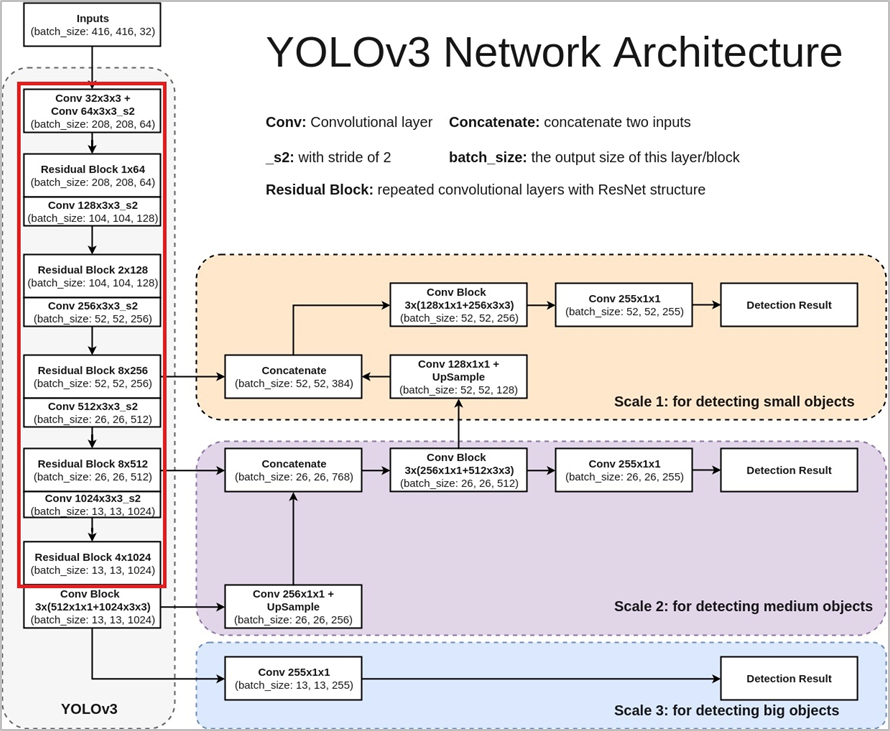
对于YOLOv3网络结构，有以下几点需要注意的：  
1.	由于网络较深，使用了残差结构。  
2.	DarkNet53网络用步长为2的卷积代替了池化层。  
3.	所有的网络层不包含全连接层，因此，输入图像的大小也是可以调整的（有些地方看到的可能是608x608，其实是一样的），而输入图像的大小同样是最小的输出特征图的32倍。  
4.	YOLOv3分别在三个尺寸的特征图进行了预测，每个尺寸的特征图使用了3个锚点。因此，输出层的维度计算方法为：(4+1+80)x3=255，因此，最后一层1x1的卷积层的数量为255。  
5.	13 x 13的特征图会通过上采样层和之前的26 x 26的特征图在通道维度拼接在一起，26 x 26的特征图再经过上采样和52 x 52的特征图拼接。  
本实验采用了基于Darknet-53的YOLOV3。  


## 实验过程

### 步骤1 下载数据

In [2]:
# 数据下载

from download import download

url = "https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com/deep-learning/mask_detection_500.tar.gz"
download(url, ".", kind="tar.gz", replace=True)

 


file_sizes: 100%|███████████████████████████| 84.7M/84.7M [01:26<00:00, 975kB/s]
Extracting tar.gz file...
Successfully downloaded / unzipped to .


'.'

以下代码用于定义相关数据集预处理的函数，如：生成Mindrecord文件，生成数据集对象等。

In [1]:
from xml.dom.minidom import parse
import xml.dom.minidom

from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import mindspore.dataset as de
from mindspore.mindrecord import FileWriter
import mindspore.dataset.vision.c_transforms as C


class Config:
    epoch_size = 60
    train_batch_size = 4
    lr = 0.001

    img_shape = [352, 640]
    feature_shape = [32, 3, 352, 640]
    num_classes = 3
    nms_max_num = 50
    _NUM_BOXES = 50

    backbone_input_shape = [64, 64, 128, 256]
    backbone_shape = [64, 128, 256, 512]
    backbone_layers = [2, 2, 2, 2]
    backbone_stride = [1, 2, 2, 2]

    ignore_threshold = 0.5
    obj_threshold = 0.3
    nms_threshold = 0.4

    loss_scale = 1024

    anchor_scales = [(5, 3), (10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (156, 198)]
    out_channel = int(len(anchor_scales) / 3 * (num_classes + 5))


def xy_local(collection, element):
    xy = collection.getElementsByTagName(element)[0]
    xy = xy.childNodes[0].data
    return xy


def filter_valid_data(image_dir):
    """Filter valid image file, which both in image_dir and anno_path."""

    label_id = {'person': 0, 'face': 1, 'mask': 2}
    all_files = os.listdir(image_dir)

    image_dict = {}
    image_files = []
    for i in all_files:
        if (i[-3:] == 'jpg' or i[-4:] == 'jpeg') and i not in image_dict:
            image_files.append(i)
            label = []
            xml_path = os.path.join(image_dir, i[:-3] + 'xml')

            if not os.path.exists(xml_path):
                label = [[0, 0, 0, 0, 0]]
                image_dict[i] = label
                continue
            DOMTree = xml.dom.minidom.parse(xml_path)
            collection = DOMTree.documentElement
            # 在集合中获取所有框
            object_ = collection.getElementsByTagName("object")
            for m in object_:
                temp = []
                name = m.getElementsByTagName('name')[0]
                class_num = label_id[name.childNodes[0].data]
                bndbox = m.getElementsByTagName('bndbox')[0]
                xmin = xy_local(bndbox, 'xmin')
                ymin = xy_local(bndbox, 'ymin')
                xmax = xy_local(bndbox, 'xmax')
                ymax = xy_local(bndbox, 'ymax')
                temp.append(int(xmin))
                temp.append(int(ymin))
                temp.append(int(xmax))
                temp.append(int(ymax))
                temp.append(class_num)
                label.append(temp)
            image_dict[i] = label
    return image_files, image_dict


def data_to_mindrecord_byte_image(image_dir, mindrecord_dir, prefix, file_num):
    """Create MindRecord file by image_dir and anno_path."""
    mindrecord_path = os.path.join(mindrecord_dir, prefix)
    writer = FileWriter(mindrecord_path, file_num)
    image_files, image_anno_dict = filter_valid_data(image_dir)

    yolo_json = {
        "image": {"type": "bytes"},
        "annotation": {"type": "int32", "shape": [-1, 5]},
        "file": {"type": "string"},
    }
    writer.add_schema(yolo_json, "yolo_json")

    for image_name in image_files:
        image_path = os.path.join(image_dir, image_name)
        with open(image_path, 'rb') as f:
            img = f.read()
        annos = np.array(image_anno_dict[image_name], dtype=np.int32)
        # print(annos.shape)
        row = {"image": img, "annotation": annos, "file": image_name}
        writer.write_raw_data([row])
    writer.commit()


def preprocess_fn(image, box, file, is_training):
    """Preprocess function for dataset."""
    config_anchors = []
    temp = Config.anchor_scales
    for i in temp:
        config_anchors += list(i)

    anchors = np.array([float(x) for x in config_anchors]).reshape(-1, 2)
    do_hsv = False
    max_boxes = Config._NUM_BOXES
    num_classes = Config.num_classes

    def _rand(a=0., b=1.):
        return np.random.rand() * (b - a) + a

    def _preprocess_true_boxes(true_boxes, anchors, in_shape=None):
        """Get true boxes."""
        num_layers = anchors.shape[0] // 3
        anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
        true_boxes = np.array(true_boxes, dtype='float32')
        input_shape = np.array(in_shape, dtype='int32')
        boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2.
        boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
        true_boxes[..., 0:2] = boxes_xy / input_shape[::-1]
        true_boxes[..., 2:4] = boxes_wh / input_shape[::-1]
        grid_shapes = [input_shape // 32, input_shape // 16, input_shape // 8]
        y_true = [np.zeros((grid_shapes[l][0], grid_shapes[l][1], len(anchor_mask[l]),
                            5 + num_classes), dtype='float32') for l in range(num_layers)]
        anchors = np.expand_dims(anchors, 0)
        anchors_max = anchors / 2.
        anchors_min = -anchors_max
        valid_mask = boxes_wh[..., 0] >= 1
        wh = boxes_wh[valid_mask]

        if len(wh) >= 1:
            wh = np.expand_dims(wh, -2)
            boxes_max = wh / 2.
            boxes_min = -boxes_max
            intersect_min = np.maximum(boxes_min, anchors_min)
            intersect_max = np.minimum(boxes_max, anchors_max)
            intersect_wh = np.maximum(intersect_max - intersect_min, 0.)
            intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
            box_area = wh[..., 0] * wh[..., 1]
            anchor_area = anchors[..., 0] * anchors[..., 1]
            iou = intersect_area / (box_area + anchor_area - intersect_area)
            best_anchor = np.argmax(iou, axis=-1)
            for t, n in enumerate(best_anchor):
                for l in range(num_layers):
                    if n in anchor_mask[l]:
                        i = np.floor(true_boxes[t, 0] * grid_shapes[l][1]).astype('int32')
                        j = np.floor(true_boxes[t, 1] * grid_shapes[l][0]).astype('int32')
                        k = anchor_mask[l].index(n)

                        c = true_boxes[t, 4].astype('int32')
                        y_true[l][j, i, k, 0:4] = true_boxes[t, 0:4]
                        y_true[l][j, i, k, 4] = 1.
                        y_true[l][j, i, k, 5 + c] = 1.

        pad_gt_box0 = np.zeros(shape=[Config._NUM_BOXES, 4], dtype=np.float32)
        pad_gt_box1 = np.zeros(shape=[Config._NUM_BOXES, 4], dtype=np.float32)
        pad_gt_box2 = np.zeros(shape=[Config._NUM_BOXES, 4], dtype=np.float32)

        mask0 = np.reshape(y_true[0][..., 4:5], [-1])
        gt_box0 = np.reshape(y_true[0][..., 0:4], [-1, 4])
        gt_box0 = gt_box0[mask0 == 1]
        pad_gt_box0[:gt_box0.shape[0]] = gt_box0

        mask1 = np.reshape(y_true[1][..., 4:5], [-1])
        gt_box1 = np.reshape(y_true[1][..., 0:4], [-1, 4])
        gt_box1 = gt_box1[mask1 == 1]
        pad_gt_box1[:gt_box1.shape[0]] = gt_box1

        mask2 = np.reshape(y_true[2][..., 4:5], [-1])
        gt_box2 = np.reshape(y_true[2][..., 0:4], [-1, 4])
        gt_box2 = gt_box2[mask2 == 1]
        pad_gt_box2[:gt_box2.shape[0]] = gt_box2

        return y_true[0], y_true[1], y_true[2], pad_gt_box0, pad_gt_box1, pad_gt_box2

    def _infer_data(img_data, input_shape, box):
        w, h = img_data.size
        input_h, input_w = input_shape
        scale = min(float(input_w) / float(w), float(input_h) / float(h))
        nw = int(w * scale)
        nh = int(h * scale)
        img_data = img_data.resize((nw, nh), Image.Resampling.BICUBIC)

        new_image = np.zeros((input_h, input_w, 3), np.float32)
        new_image.fill(128)
        img_data = np.array(img_data)
        if len(img_data.shape) == 2:
            img_data = np.expand_dims(img_data, axis=-1)
            img_data = np.concatenate([img_data, img_data, img_data], axis=-1)

        dh = int((input_h - nh) / 2)
        dw = int((input_w - nw) / 2)
        new_image[dh:(nh + dh), dw:(nw + dw), :] = img_data
        new_image /= 255.
        new_image = np.transpose(new_image, (2, 0, 1))
        new_image = np.expand_dims(new_image, 0)
        return new_image, np.array([h, w], np.float32), box

    def _data_aug(image, box, is_training, jitter=0.3, hue=0.1, sat=1.5, val=1.5, image_size=(352, 640)):

        """Data augmentation function."""
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)

        iw, ih = image.size
        ori_image_shape = np.array([ih, iw], np.int32)
        h, w = image_size

        if not is_training:
            return _infer_data(image, image_size, box)

        flip = _rand() < .5
        # correct boxes
        box_data = np.zeros((max_boxes, 5))
        flag = 0

        while True:
            # Prevent the situation that all boxes are eliminated
            new_ar = float(w) / float(h) * _rand(1 - jitter, 1 + jitter) / \
                     _rand(1 - jitter, 1 + jitter)
            scale = _rand(0.25, 2)

            if new_ar < 1:
                nh = int(scale * h)
                nw = int(nh * new_ar)
            else:
                nw = int(scale * w)
                nh = int(nw / new_ar)

            dx = int(_rand(0, w - nw))
            dy = int(_rand(0, h - nh))
            flag = flag + 1

            if len(box) >= 1:
                t_box = box.copy()
                np.random.shuffle(t_box)
                t_box[:, [0, 2]] = t_box[:, [0, 2]] * float(nw) / float(iw) + dx
                t_box[:, [1, 3]] = t_box[:, [1, 3]] * float(nh) / float(ih) + dy
                if flip:
                    t_box[:, [0, 2]] = w - t_box[:, [2, 0]]
                t_box[:, 0:2][t_box[:, 0:2] < 0] = 0
                t_box[:, 2][t_box[:, 2] > w] = w
                t_box[:, 3][t_box[:, 3] > h] = h
                box_w = t_box[:, 2] - t_box[:, 0]
                box_h = t_box[:, 3] - t_box[:, 1]
                t_box = t_box[np.logical_and(box_w > 1, box_h > 1)]  # discard invalid box

            if len(t_box) >= 1:
                box = t_box
                break

        box_data[:len(box)] = box
        # resize image
        image = image.resize((nw, nh), Image.Resampling.BICUBIC)
        image = image.resize((nw, nh), Image.Resampling.BICUBIC)
        # place image
        new_image = Image.new('RGB', (w, h), (128, 128, 128))
        new_image.paste(image, (dx, dy))
        image = new_image

        # flip image or not
        if flip:
            image = image.transpose(Image.Transpose.FLIP_LEFT_RIGHT)

        # convert image to gray or not
        gray = _rand() < .25
        if gray:
            image = image.convert('L').convert('RGB')

        # when the channels of image is 1
        image = np.array(image)
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)
            image = np.concatenate([image, image, image], axis=-1)

        # distort image
        hue = _rand(-hue, hue)
        sat = _rand(1, sat) if _rand() < .5 else 1 / _rand(1, sat)
        val = _rand(1, val) if _rand() < .5 else 1 / _rand(1, val)
        image_data = image / 255.
        if do_hsv:
            x = rgb_to_hsv(image_data)
            x[..., 0] += hue
            x[..., 0][x[..., 0] > 1] -= 1
            x[..., 0][x[..., 0] < 0] += 1
            x[..., 1] *= sat
            x[..., 2] *= val
            x[x > 1] = 1
            x[x < 0] = 0
            image_data = hsv_to_rgb(x)  # numpy array, 0 to 1
        image_data = image_data.astype(np.float32)

        # preprocess bounding boxes
        bbox_true_1, bbox_true_2, bbox_true_3, gt_box1, gt_box2, gt_box3 = \
            _preprocess_true_boxes(box_data, anchors, image_size)

        return image_data, bbox_true_1, bbox_true_2, bbox_true_3, \
               ori_image_shape, gt_box1, gt_box2, gt_box3

    if is_training:
        images, bbox_1, bbox_2, bbox_3, image_shape, gt_box1, gt_box2, gt_box3 = _data_aug(image, box, is_training)
        return images, bbox_1, bbox_2, bbox_3, gt_box1, gt_box2, gt_box3

    images, shape, anno = _data_aug(image, box, is_training)
    return images, shape, anno, file


def create_yolo_dataset(mindrecord_dir, batch_size=32, repeat_num=1, device_num=1, rank=0,
                        is_training=True, num_parallel_workers=8):
    """Creatr YOLOv3 dataset with MindDataset."""
    ds = de.MindDataset(mindrecord_dir, num_shards=device_num,
                        shard_id=rank,
                        num_parallel_workers=num_parallel_workers,
                        shuffle=is_training)
    ds = ds.project(["image", "annotation", "file"])
    decode = de.vision.Decode()
    ds = ds.map(operations=decode, input_columns=["image"])
    compose_map_func = (lambda image, annotation, file: preprocess_fn(image, annotation, file, is_training))

    if is_training:
        hwc_to_chw = de.vision.HWC2CHW()
        ds = ds.map(operations=compose_map_func, input_columns=["image", "annotation", "file"],
                    output_columns=["image", "bbox_1", "bbox_2", "bbox_3", "gt_box1", "gt_box2", "gt_box3"],
                    num_parallel_workers=num_parallel_workers)
        ds = ds.project(["image", "bbox_1", "bbox_2", "bbox_3", "gt_box1", "gt_box2", "gt_box3"])
        ds = ds.map(operations=hwc_to_chw, input_columns=["image"], num_parallel_workers=num_parallel_workers)

        print('Datasize train:', ds.get_dataset_size())
        ds = ds.batch(batch_size, drop_remainder=True)
        ds = ds.repeat(repeat_num)
    else:
        ds = ds.map(operations=compose_map_func, input_columns=["image", "annotation", "file"],
                    output_columns=["image", "image_shape", "annotation", "file"],
                    num_parallel_workers=num_parallel_workers)
        ds = ds.project(["image", "image_shape", "annotation", "file"])
        print('Datasize eval:', ds.get_dataset_size())

    return ds

### 步骤2 定义网络  

以下代码实现生成YOLO网络所需的相关类。

In [2]:
"""YOLOv3 based on ResNet18."""
import mindspore as ms
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal


class _conv2d(nn.Cell):
    """Create Conv2D with padding."""

    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(_conv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size=kernel_size, stride=stride, padding=0, pad_mode='same',
                              weight_init=TruncatedNormal(0.02))

    def construct(self, x):
        x = self.conv(x)
        return x


def _conv_bn_relu(in_channel, out_channel, ksize, stride=1, padding=0, dilation=1, alpha=0.1,
                  momentum=0.99, pad_mode="same"):
    return nn.SequentialCell(
        [nn.Conv2d(in_channel, out_channel, kernel_size=ksize, stride=stride,
                   padding=padding, dilation=dilation, pad_mode=pad_mode),
         nn.BatchNorm2d(out_channel, momentum=momentum),
         nn.LeakyReLU(alpha)]
    )


class BasicBlock(nn.Cell):
    # expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, momentum=0.99):
        super(BasicBlock, self).__init__()
        self.conv1 = _conv2d(in_channels, out_channels, 3, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=momentum)
        self.conv2 = _conv2d(out_channels, out_channels, 3)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=momentum)
        self.relu = nn.ReLU()
        self.down_sample_layer = None
        self.downsample = (in_channels != out_channels)
        if self.downsample:
            self.down_sample_layer = _conv2d(in_channels, out_channels, 1, stride=stride)


    def construct(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample:
            identity = self.down_sample_layer(identity)

        out = ops.add(x, identity)
        out = self.relu(out)

        return out


class ResNet(nn.Cell):

    def __init__(self, block, layer_nums, in_channels, out_channels, strides=None, num_classes=80):
        super(ResNet, self).__init__()
        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, inchannel, outchannel list must be 4!")

        self.conv1 = _conv2d(3, 64, 7, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')

        self.layer1 = self._make_layer(block, layer_nums[0], in_channel=in_channels[0],
                                       out_channel=out_channels[0], stride=strides[0])
        self.layer2 = self._make_layer(block, layer_nums[1], in_channel=in_channels[1],
                                       out_channel=out_channels[1], stride=strides[1])
        self.layer3 = self._make_layer(block, layer_nums[2], in_channel=in_channels[2],
                                       out_channel=out_channels[2], stride=strides[2])
        self.layer4 = self._make_layer(block, layer_nums[3], in_channel=in_channels[3],
                                       out_channel=out_channels[3], stride=strides[3])
        self.num_classes = num_classes
        if num_classes:
            self.reduce_mean = ops.ReduceMean(keep_dims=True)
            self.end_point = nn.Dense(out_channels[3], num_classes, has_bias=True,
                                      weight_init=TruncatedNormal(0.02), bias_init=TruncatedNormal(0.02))

    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        layers = []
        resblk = block(in_channel, out_channel, stride=stride)
        layers.append(resblk)
        for _ in range(1, layer_num - 1):
            resblk = block(out_channel, out_channel, stride=1)
            layers.append(resblk)
        resblk = block(out_channel, out_channel, stride=1)
        layers.append(resblk)

        return nn.SequentialCell(layers)

    def construct(self, x):
        c3 = self.layer2(self.layer1(self.maxpool(self.relu(self.bn1(self.conv1(x))))))
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        out = c5
        if self.num_classes:
            out = self.reduce_mean(c5, (2, 3))
            out = ops.squeeze(out, axis=(2, 3))
            out = self.end_point(out)

        return c3, c4, out


def resnet18(class_num=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], [64, 64, 128, 256], [64, 128, 256, 512],
                  [1, 2, 2, 2], num_classes=class_num)


class YoloBlock(nn.Cell):
    def __init__(self, in_channels, out_chls, out_channels):
        super(YoloBlock, self).__init__()
        out_chls_2 = out_chls * 2
        self.conv0 = _conv_bn_relu(in_channels, out_chls, ksize=1)
        self.conv1 = _conv_bn_relu(out_chls, out_chls_2, ksize=3)

        self.conv2 = _conv_bn_relu(out_chls_2, out_chls, ksize=1)
        self.conv3 = _conv_bn_relu(out_chls, out_chls_2, ksize=3)

        self.conv4 = _conv_bn_relu(out_chls_2, out_chls, ksize=1)
        self.conv5 = _conv_bn_relu(out_chls, out_chls_2, ksize=3)

        self.conv6 = nn.Conv2d(out_chls_2, out_channels, kernel_size=1, stride=1, has_bias=True)

    def construct(self, x):

        c5 = self.conv4(self.conv3(self.conv2(self.conv1(self.conv0(x)))))
        c6 = self.conv5(c5)

        out = self.conv6(c6)
        return c5, out


class YOLOv3(nn.Cell):

    def __init__(self, feature_shape, backbone_shape, backbone, out_channel):
        super(YOLOv3, self).__init__()
        self.out_channel = out_channel
        self.net = backbone
        self.backblock0 = YoloBlock(backbone_shape[-1], out_chls=backbone_shape[-2], out_channels=out_channel)

        self.conv1 = _conv_bn_relu(in_channel=backbone_shape[-2], out_channel=backbone_shape[-2] // 2, ksize=1)
        self.upsample1 = ops.ResizeNearestNeighbor((feature_shape[2] // 16, feature_shape[3] // 16))
        self.backblock1 = YoloBlock(in_channels=backbone_shape[-2] + backbone_shape[-3],
                                    out_chls=backbone_shape[-3],
                                    out_channels=out_channel)

        self.conv2 = _conv_bn_relu(in_channel=backbone_shape[-3], out_channel=backbone_shape[-3] // 2, ksize=1)
        self.upsample2 = ops.ResizeNearestNeighbor((feature_shape[2] // 8, feature_shape[3] // 8))
        self.backblock2 = YoloBlock(in_channels=backbone_shape[-3] + backbone_shape[-4],
                                    out_chls=backbone_shape[-4],
                                    out_channels=out_channel)

    def construct(self, x):
        # input_shape of x is (batch_size, 3, h, w)
        # feature_map1 is (batch_size, backbone_shape[2], h/8, w/8)
        # feature_map2 is (batch_size, backbone_shape[3], h/16, w/16)
        # feature_map3 is (batch_size, backbone_shape[4], h/32, w/32)
        feature_map1, feature_map2, feature_map3 = self.net(x)
        con1, big_object_output = self.backblock0(feature_map3)

        con1 = self.conv1(con1)
        ups1 = self.upsample1(con1)
        con1 = ops.cat((ups1, feature_map2), axis=1)
        con2, medium_object_output = self.backblock1(con1)

        con2 = self.conv2(con2)
        ups2 = self.upsample2(con2)
        con3 = ops.cat((ups2, feature_map1), axis=1)
        _, small_object_output = self.backblock2(con3)

        return big_object_output, medium_object_output, small_object_output


class DetectionBlock(nn.Cell):
    def __init__(self, scale, config, train):
        super(DetectionBlock, self).__init__()
        self.train = train

        self.config = config
        if scale == 's':
            idx = (0, 1, 2)
        elif scale == 'm':
            idx = (3, 4, 5)
        elif scale == 'l':
            idx = (6, 7, 8)
        else:
            raise KeyError("Invalid scale value for DetectionBlock")
        self.anchors = Tensor([self.config.anchor_scales[i] for i in idx], ms.float32)
        self.num_anchors_per_scale = 3
        self.num_attrib = 4 + 1 + self.config.num_classes
        self.ignore_threshold = 0.5
        self.lambda_coord = 1

        self.sigmoid = nn.Sigmoid()
        self.input_shape = Tensor(tuple(config.img_shape[::-1]), ms.float32)

    def construct(self, x):
        num_batch = ops.shape(x)[0]
        grid_size = ops.shape(x)[2:4]

        # Reshape and transpose the feature to [n, 3, grid_size[0], grid_size[1], num_attrib]
        prediction = ops.reshape(x, (num_batch, self.num_anchors_per_scale, self.num_attrib,
                                     grid_size[0], grid_size[1]))
        prediction = ops.transpose(prediction, (0, 3, 4, 1, 2))

        range_x = range(grid_size[1])
        range_y = range(grid_size[0])
        grid_x = ops.Cast()(ops.tuple_to_array(range_x), ms.float32)
        grid_y = ops.Cast()(ops.tuple_to_array(range_y), ms.float32)
        grid_x = ops.tile(ops.reshape(grid_x, (1, 1, -1, 1, 1)), (1, grid_size[0], 1, 1, 1))
        grid_y = ops.tile(ops.reshape(grid_y, (1, -1, 1, 1, 1)), (1, 1, grid_size[1], 1, 1))
        grid = ops.cat((grid_x, grid_y), axis=-1)

        box_xy = prediction[:, :, :, :, :2]
        box_wh = prediction[:, :, :, :, 2:4]
        box_confidence = prediction[:, :, :, :, 4:5]
        box_probs = prediction[:, :, :, :, 5:]

        box_xy = (self.sigmoid(box_xy) + grid) / ops.Cast()(ops.tuple_to_array((grid_size[1], grid_size[0])), ms.float32)
        box_wh = ops.exp(box_wh) * self.anchors / self.input_shape
        box_confidence = self.sigmoid(box_confidence)
        box_probs = self.sigmoid(box_probs)

        if self.train:
            return grid, prediction, box_xy, box_wh

        return box_xy, box_wh, box_confidence, box_probs


def IOU(box1, box2):
    box1_xy = box1[:, :, :, :, :, :2]
    box1_wh = box1[:, :, :, :, :, 2:4]
    box1_mins = box1_xy - box1_wh / ops.scalar_to_tensor(2.0)
    box1_maxs = box1_xy + box1_wh / ops.scalar_to_tensor(2.0)

    box2_xy = box2[:, :, :, :, :, :2]
    box2_wh = box2[:, :, :, :, :, 2:4]
    box2_mins = box2_xy - box2_wh / ops.scalar_to_tensor(2.0)
    box2_maxs = box2_xy + box2_wh / ops.scalar_to_tensor(2.0)

    intersect_mins = ops.maximum(box1_mins, box2_mins)
    intersect_maxs = ops.minimum(box1_maxs, box2_maxs)
    intersect_wh = ops.maximum(intersect_maxs - intersect_mins, ops.scalar_to_tensor(0.0))

    intersect_area = ops.squeeze(intersect_wh[:, :, :, :, :, 0:1], axis=-1) * \
                     ops.squeeze(intersect_wh[:, :, :, :, :, 1:2], axis=-1)
    box1_area = ops.squeeze(box1_wh[:, :, :, :, :, 0:1], axis=-1) * ops.squeeze(box1_wh[:, :, :, :, :, 1:2], axis=-1)
    box2_area = ops.squeeze(box2_wh[:, :, :, :, :, 0:1], axis=-1) * ops.squeeze(box2_wh[:, :, :, :, :, 1:2], axis=-1)

    iou = intersect_area / (box1_area + box2_area - intersect_area)
    return iou


class YoloLossBlock(nn.Cell):
    def __init__(self, scale, config):
        super(YoloLossBlock, self).__init__()
        self.config = config
        if scale == 's':
            idx = (0, 1, 2)
        elif scale == 'm':
            idx = (3, 4, 5)
        elif scale == 'l':
            idx = (6, 7, 8)
        else:
            raise KeyError("Invalid scale value for DetectionBlock")
        self.anchors = Tensor([self.config.anchor_scales[i] for i in idx], ms.float32)
        self.ignore_threshold = Tensor(self.config.ignore_threshold, ms.float32)
        self.cross_entropy = ops.SigmoidCrossEntropyWithLogits()
        self.reduce_sum = ops.ReduceSum()
        self.reduce_max = ops.ReduceMax(keep_dims=False)
        self.input_shape = Tensor(tuple(config.img_shape[::-1]), ms.float32)

    def construct(self, grid, prediction, pred_xy, pred_wh, y_true, gt_box):

        object_mask = y_true[:, :, :, :, 4:5]
        class_probs = y_true[:, :, :, :, 5:]

        grid_shape = ops.shape(prediction)[1:3]
        grid_shape = ops.Cast()(ops.tuple_to_array(grid_shape[::-1]), ms.float32)

        pred_boxes = ops.cat((pred_xy, pred_wh), axis=-1)
        true_xy = y_true[:, :, :, :, :2] * grid_shape - grid
        true_wh = y_true[:, :, :, :, 2:4]
        true_wh = ops.select(ops.equal(true_wh, 0.0),
                             ops.fill(ops.DType()(true_wh), ops.shape(true_wh), 1.0),
                             true_wh)
        true_wh =ops.log(true_wh / self.anchors * self.input_shape)
        box_loss_scale = 2 - y_true[:, :, :, :, 2:3] * y_true[:, :, :, :, 3:4]

        gt_shape = ops.shape(gt_box)
        gt_box = ops.reshape(gt_box, (gt_shape[0], 1, 1, 1, gt_shape[1], gt_shape[2]))

        iou = IOU(ops.expand_dims(pred_boxes, -2), gt_box)  # [batch, grid[0], grid[1], num_anchor, num_gt]
        best_iou = self.reduce_max(iou, -1)  # [batch, grid[0], grid[1], num_anchor]
        ignore_mask = best_iou < self.ignore_threshold
        ignore_mask = ops.Cast()(ignore_mask, ms.float32)
        ignore_mask = ops.expand_dims(ignore_mask, -1)
        ignore_mask = ops.stop_gradient(ignore_mask)

        xy_loss = object_mask * box_loss_scale * self.cross_entropy(prediction[:, :, :, :, :2], true_xy)
        wh_loss = object_mask * box_loss_scale * 0.5 * ops.square(true_wh - prediction[:, :, :, :, 2:4])

        confidence_loss = self.cross_entropy(prediction[:, :, :, :, 4:5], object_mask)
        confidence_loss = object_mask * confidence_loss + (1 - object_mask) * confidence_loss * ignore_mask
        class_loss = object_mask * self.cross_entropy(prediction[:, :, :, :, 5:], class_probs)

        # Get smooth loss
        xy_loss = self.reduce_sum(xy_loss, ())
        wh_loss = self.reduce_sum(wh_loss, ())
        confidence_loss = self.reduce_sum(confidence_loss, ())
        class_loss = self.reduce_sum(class_loss, ())

        loss = xy_loss + wh_loss + confidence_loss + class_loss
        return loss / ops.shape(prediction)[0]


class yolov3_resnet18(nn.Cell):

    def __init__(self, config, train=True):
        super(yolov3_resnet18, self).__init__()
        self.config = config

        # YOLOv3 network
        self.feature_map = YOLOv3(feature_shape=self.config.feature_shape,
                                  backbone=ResNet(BasicBlock, self.config.backbone_layers,
                                                  self.config.backbone_input_shape, self.config.backbone_shape,
                                                  self.config.backbone_stride,  num_classes=None),
                                  backbone_shape=self.config.backbone_shape,
                                  out_channel=self.config.out_channel)

        # prediction on the default anchor boxes
        self.detect_1 = DetectionBlock('l', self.config, train=train)
        self.detect_2 = DetectionBlock('m', self.config, train=train)
        self.detect_3 = DetectionBlock('s', self.config, train=train)

    def construct(self, x):
        big_object_output, medium_object_output, small_object_output = self.feature_map(x)

        output_big = self.detect_1(big_object_output)
        output_me = self.detect_2(medium_object_output)
        output_small = self.detect_3(small_object_output)

        return output_big, output_me, output_small


### 步骤3 定义评价指标  

以下代码定义了评价模型结果的相关指标，如：IOU等

In [3]:
# 计算原始图片大小的框和每个框的分数。
class YoloBoxScores(nn.Cell):

    def __init__(self, config):
        super(YoloBoxScores, self).__init__()
        self.input_shape = Tensor(np.array(config.img_shape), ms.float32)
        self.num_classes = config.num_classes

    def construct(self, box_xy, box_wh, box_confidence, box_probs, image_shape):
        batch_size = ops.shape(box_xy)[0]
        x = box_xy[:, :, :, :, 0:1]
        y = box_xy[:, :, :, :, 1:2]
        box_yx = ops.cat((y, x), axis=-1)
        w = box_wh[:, :, :, :, 0:1]
        h = box_wh[:, :, :, :, 1:2]
        box_hw = ops.cat((h, w), axis=-1)

        new_shape = ops.round(image_shape * ops.ReduceMin()(self.input_shape / image_shape))
        offset = (self.input_shape - new_shape) / 2.0 / self.input_shape
        scale = self.input_shape / new_shape
        box_yx = (box_yx - offset) * scale
        box_hw = box_hw * scale

        box_min = box_yx - box_hw / 2.0
        box_max = box_yx + box_hw / 2.0
        boxes = ops.cat((box_min[:, :, :, :, 0:1], box_min[:, :, :, :, 1:2],
                        box_max[:, :, :, :, 0:1], box_max[:, :, :, :, 1:2]), axis=-1)
        image_scale = ops.tile(image_shape, (1, 2))
        boxes = boxes * image_scale
        boxes = ops.reshape(boxes, (batch_size, -1, 4))
        boxes_scores = box_confidence * box_probs
        boxes_scores = ops.reshape(boxes_scores, (batch_size, -1, self.num_classes))
        return boxes, boxes_scores

    
def tobox(boxes, box_scores):
    """Calculate precision and recall of predicted bboxes."""
    config = Config()
    num_classes = config.num_classes
    mask = box_scores >= config.obj_threshold
    boxes_ = []
    scores_ = []
    classes_ = []
    max_boxes = config.nms_max_num
    for c in range(num_classes):
        class_boxes = np.reshape(boxes, [-1, 4])[np.reshape(mask[:, c], [-1])]
        class_box_scores = np.reshape(box_scores[:, c], [-1])[np.reshape(mask[:, c], [-1])]
        nms_index = apply_nms(class_boxes, class_box_scores, config.nms_threshold, max_boxes)
        class_boxes = class_boxes[nms_index]
        class_box_scores = class_box_scores[nms_index]
        classes = np.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)

    boxes = np.concatenate(boxes_, axis=0)
    classes = np.concatenate(classes_, axis=0)
    scores = np.concatenate(scores_, axis=0)

    return boxes, classes, scores


def calc_iou(bbox_pred, bbox_ground):
    """Calculate iou of predicted bbox and ground truth."""
    x1 = bbox_pred[0]
    y1 = bbox_pred[1]
    width1 = bbox_pred[2] - bbox_pred[0]
    height1 = bbox_pred[3] - bbox_pred[1]

    x2 = bbox_ground[0]
    y2 = bbox_ground[1]
    width2 = bbox_ground[2] - bbox_ground[0]
    height2 = bbox_ground[3] - bbox_ground[1]

    endx = max(x1 + width1, x2 + width2)
    startx = min(x1, x2)
    width = width1 + width2 - (endx - startx)

    endy = max(y1 + height1, y2 + height2)
    starty = min(y1, y2)
    height = height1 + height2 - (endy - starty)

    if width <= 0 or height <= 0:
        iou = 0
    else:
        area = width * height
        area1 = width1 * height1
        area2 = width2 * height2
        iou = area * 1. / (area1 + area2 - area)

    return iou


def apply_nms(all_boxes, all_scores, thres, max_boxes):
    """Apply NMS to bboxes."""
    x1 = all_boxes[:, 0]
    y1 = all_boxes[:, 1]
    x2 = all_boxes[:, 2]
    y2 = all_boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = all_scores.argsort()[::-1]
    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)
        if len(keep) >= max_boxes:
            break
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= thres)[0]
        order = order[inds + 1]
    return keep


def metrics(pred_data):
    """Calculate precision and recall of predicted bboxes."""
    config = Config()
    num_classes = config.num_classes
    count_corrects = [1e-6 for _ in range(num_classes)]
    count_grounds = [1e-6 for _ in range(num_classes)]
    count_preds = [1e-6 for _ in range(num_classes)]

    for i, sample in enumerate(pred_data):
        gt_anno = sample["annotation"]
        box_scores = sample['box_scores']
        boxes = sample['boxes']
        mask = box_scores >= config.obj_threshold
        boxes_ = [], scores_ = [], classes_ = []
        max_boxes = config.nms_max_num
        for c in range(num_classes):
            class_boxes = np.reshape(boxes, [-1, 4])[np.reshape(mask[:, c], [-1])]
            class_box_scores = np.reshape(box_scores[:, c], [-1])[np.reshape(mask[:, c], [-1])]
            nms_index = apply_nms(class_boxes, class_box_scores, config.nms_threshold, max_boxes)
            class_boxes = class_boxes[nms_index]
            class_box_scores = class_box_scores[nms_index]
            classes = np.ones_like(class_box_scores, 'int32') * c
            boxes_.append(class_boxes)
            scores_.append(class_box_scores)
            classes_.append(classes)

        boxes = np.concatenate(boxes_, axis=0)
        classes = np.concatenate(classes_, axis=0)

        # metric
        count_correct = [1e-6 for _ in range(num_classes)]
        count_ground = [1e-6 for _ in range(num_classes)]
        count_pred = [1e-6 for _ in range(num_classes)]

        for anno in gt_anno:
            count_ground[anno[4]] += 1

        for box_index, box in enumerate(boxes):
            bbox_pred = [box[1], box[0], box[3], box[2]]
            count_pred[classes[box_index]] += 1

            for anno in gt_anno:
                class_ground = anno[4]

                if classes[box_index] == class_ground:
                    iou = calc_iou(bbox_pred, anno)
                    if iou >= 0.5:
                        count_correct[class_ground] += 1
                        break

        count_corrects = [count_corrects[i] + count_correct[i] for i in range(num_classes)]
        count_preds = [count_preds[i] + count_pred[i] for i in range(num_classes)]
        count_grounds = [count_grounds[i] + count_ground[i] for i in range(num_classes)]

    precision = np.array([count_corrects[ix] / count_preds[ix] for ix in range(num_classes)])
    recall = np.array([count_corrects[ix] / count_grounds[ix] for ix in range(num_classes)])
    return precision, recall

### 步骤4	定义训练网络的函数和开始训练

In [4]:
'''train YOLOv3 example'''

import mindspore.nn as nn
from mindspore import ops
from mindspore.common.initializer import initializer

from mindspore.common import set_seed

set_seed(1)


def cosine_lr(base_lr, decay_steps, total_steps):
    lr = []
    for i in range(total_steps):
        step_ = min(i, decay_steps)
        lr.append(base_lr * 0.5 * (1 + np.cos(np.pi * step_ / decay_steps)))
    lr = np.array(lr).astype(np.float32)
    return lr


def init_net_param(network, init_value='ones'):
    """Init the parameters in network."""
    params = network.trainable_params()
    for p in params:
        if isinstance(p.data, Tensor) and 'beta' not in p.name and 'gamma' not in p.name and 'bias' not in p.name:
            p.set_data(initializer(init_value, p.data.shape, p.data.dtype))

In [6]:
import os
import time
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from mindspore import context, Tensor
from mindspore import load_checkpoint, load_param_into_net
config = Config()

In [5]:

print("Start create dataset!")
data_path = './mask_detection_500'
mindrecord_dir_train = os.path.join(data_path, 'mindrecord/train')
prefix = "yolo.mindrecord"

if os.path.exists(mindrecord_dir_train) and os.listdir(mindrecord_dir_train):
    print('The mindrecord file had exists!')
else:
    os.makedirs(mindrecord_dir_train)
    image_dir = os.path.join(data_path, "train")
    print("Creating Mindrecord.")
    data_to_mindrecord_byte_image(image_dir, mindrecord_dir_train, prefix, 1)
    print("Create Mindrecord Done, at {}".format(mindrecord_dir_train))

mindrecord_file = os.path.join(mindrecord_dir_train, prefix)
print('mindrecord_file:', mindrecord_file)

if os.path.exists(mindrecord_dir_train) and os.listdir(mindrecord_dir_train):
    print('The mindrecord file had exists!')
else:
    print("Mindrecord no exits!")

dataset = create_yolo_dataset(mindrecord_file, batch_size=config.train_batch_size, device_num=1, rank=0)

step_size = dataset.get_dataset_size()
print('The step size: ', step_size)
print("Create dataset done!")

net_yolo = yolov3_resnet18(Config(), train=True)

# load pretrained model
loss_big = YoloLossBlock('l', Config())
loss_me = YoloLossBlock('m', Config())
loss_small = YoloLossBlock('s', Config())

# 函数式编程
def forward_fn(data):
    yolo_out = net_yolo(data['image'])
    loss_l = loss_big(yolo_out[0][0], yolo_out[0][1], yolo_out[0][2], yolo_out[0][3],
                      data['bbox_1'], data['gt_box1'])
    loss_m = loss_me(yolo_out[1][0], yolo_out[1][1], yolo_out[1][2], yolo_out[1][3],
                     data['bbox_2'], data['gt_box2'])
    loss_s = loss_small(yolo_out[2][0], yolo_out[2][1], yolo_out[2][2], yolo_out[2][3],
                        data['bbox_3'], data['gt_box3'])
    net_loss = loss_l + loss_m + loss_s
    return net_loss

total_steps = config.epoch_size * step_size
lr = Tensor(cosine_lr(config.lr, total_steps, total_steps))

opt = nn.Adam(filter(lambda x: x.requires_grad, net_yolo.get_parameters()), lr,
              loss_scale=float(config.loss_scale))

grad_fn = ms.value_and_grad(forward_fn, None, net_yolo.trainable_params())

def train_step(data):
    loss, grads = grad_fn(data)
    loss = ops.depend(loss, opt(grads))
    return loss

save_ckpt_dir = './ckpt/'
print('save_ckpt_dir: ', save_ckpt_dir)
for epoch in range(config.epoch_size):
    epoch_loss = []
    for step, data in enumerate(dataset.create_dict_iterator()):
        begin_time = time.time()
        loss = train_step(data)
        end_time = time.time()
        times = end_time - begin_time
        loss = loss.asnumpy()
        epoch_loss.append(loss)
        if step % 1 == 0:
            print(f"Epoch:[{int(epoch + 1):>3d}/{int(config.epoch_size):>3d}], "
                  f"step:[{int(step):>4d}/{int(step_size):>4d}], "
                  f"loss:{loss:>4f} , "
                  f"time:{times:>3f}s, ")
    m_loss = sum(epoch_loss) / step_size
    print(f"Epoch:[{int(epoch + 1):>3d}/{int(config.epoch_size):>3d}], "
          f"Mean loss:{m_loss:>4f}")
    if epoch > 10:
        if (epoch + 1) % 5 == 0:
            os.makedirs(save_ckpt_dir, exist_ok=True)
            ms.save_checkpoint(net_yolo, os.path.join(save_ckpt_dir, f"./yolov3_{epoch + 1}_{step_size}.ckpt"))

Start create dataset!
The mindrecord file had exists!
mindrecord_file: ./mask_detection_500/mindrecord/train/yolo.mindrecord
The mindrecord file had exists!
Datasize train: 500
The step size:  125
Create dataset done!
save_ckpt_dir:  ./ckpt/ckpt_202306291122/
Epoch:[  1/ 60], step:[   0/ 125], loss:9646.517578 , time:5.935603s, 
Epoch:[  1/ 60], step:[   1/ 125], loss:9640.242188 , time:5.945805s, 
Epoch:[  1/ 60], step:[   2/ 125], loss:9597.505859 , time:3.401558s, 
Epoch:[  1/ 60], step:[   3/ 125], loss:9617.201172 , time:3.051895s, 
Epoch:[  1/ 60], step:[   4/ 125], loss:9585.890625 , time:3.022654s, 
Epoch:[  1/ 60], step:[   5/ 125], loss:9152.977539 , time:2.955293s, 
Epoch:[  1/ 60], step:[   6/ 125], loss:9244.160156 , time:2.710561s, 
... 
Epoch:[ 32/ 60], step:[  96/ 125], loss:60.504795 , time:2.672873s, 
Epoch:[ 32/ 60], step:[  97/ 125], loss:118.925575 , time:2.491642s, 
Epoch:[ 32/ 60], step:[  98/ 125], loss:95.362991 , time:2.661912s, 
Epoch:[ 32/ 60], step:[  99/ 1

### 步骤5 测试网络模型

ckpt_path: ./ckpt/ckpt_202306291122/yolov3_60_125.ckpt
cfg.ckpt_path exists
Start create dataset!
The mindrecord file had exists!
mindrecord_file: ./mask_detection_500/mindrecord/test/yolo.mindrecord
Start Eval!
Datasize eval: 8
Model load over!
total images num:  8
Processing, please wait a moment.
image_file: J_video3_clip1-frame-00039.jpg


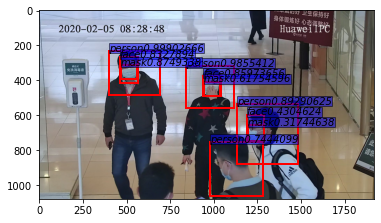

image_file: hilens_2_-000000059.jpg


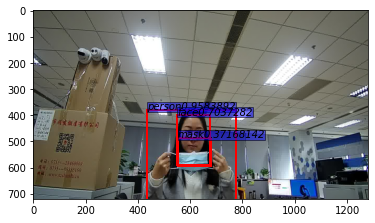

image_file: 02-02_video12-frame-00249.jpg


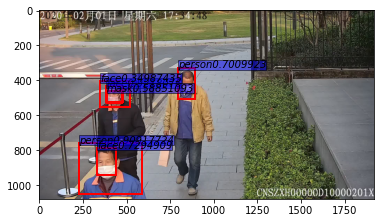

image_file: hilens_2_-000000038.jpg


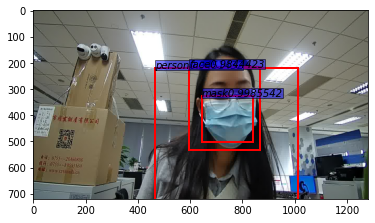

image_file: H_gate_frames_10150.jpg


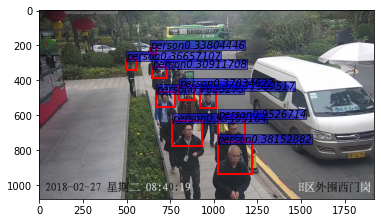

image_file: H_gate_frames_10350.jpg


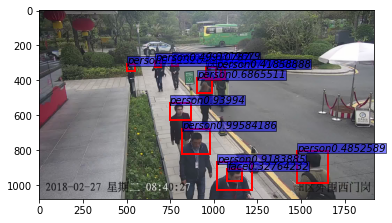

image_file: 02-03_video01-frame-00111.jpeg


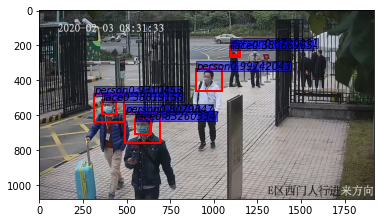

image_file: 02-03_video03-frame-15841.jpeg


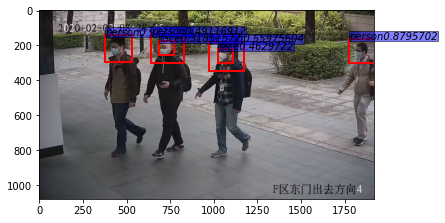

In [8]:
ckpt_path = './ckpt/yolov3_60_125.ckpt'

print('ckpt_path:', ckpt_path)

if os.path.exists(ckpt_path):
    print('cfg.ckpt_path exists')
else:
    raise ValueError('cfg.ckpt_path does not exist！')

print("Start create dataset!")
data_path = './mask_detection_500'
mindrecord_dir_test = os.path.join(data_path, 'mindrecord/test')
prefix = "yolo.mindrecord"

image_dir = os.path.join(data_path, "test")

if os.path.exists(mindrecord_dir_test) and os.listdir(mindrecord_dir_test):
    print('The mindrecord file had exists!')
else:
    os.makedirs(mindrecord_dir_test)
    print("Creating Mindrecord.")
    data_to_mindrecord_byte_image(image_dir, mindrecord_dir_test, prefix, 1)
    print("Create Mindrecord Done, at {}".format(mindrecord_dir_test))

mindrecord_file = os.path.join(mindrecord_dir_test, prefix)

print('mindrecord_file:', mindrecord_file)

print("Start Eval!")

"""Yolov3 evaluation."""

ds = create_yolo_dataset(mindrecord_file, batch_size=1, is_training=False)

config = Config()

net = yolov3_resnet18(config, train=False)

net.set_train(False)

parameter_dict = load_checkpoint(ckpt_path)

load_param_into_net(net, parameter_dict)
print('Model load over!')

box_score_0 = YoloBoxScores(config)
box_score_1 = YoloBoxScores(config)
box_score_2 = YoloBoxScores(config)

total = ds.get_dataset_size()
print("========================================")
print("total images num: ", total)
print("Processing, please wait a moment.")

num_class = {0: 'person', 1: 'face', 2: 'mask'}
for data in ds.create_dict_iterator(output_numpy=True):
    img_np = data['image']
    image_shape = data['image_shape']
    annotation = data['annotation']
    image_file = data['file']

    image_file = image_file.tobytes().decode('ascii').encode('ascii')
    image_file = ''.join(chr(x) if x else "" for x in image_file)
    print('image_file:', image_file)
    yolo_output = net(Tensor(img_np))
    image_shape = Tensor(image_shape)
    boxes_0, boxes_scores_0 = box_score_0(*yolo_output[0], image_shape)
    boxes_1, boxes_scores_1 = box_score_1(*yolo_output[1], image_shape)
    boxes_2, boxes_scores_2 = box_score_2(*yolo_output[2], image_shape)
    boxes = ops.cat((boxes_0, boxes_1, boxes_2), axis=1)
    boxes_scores = ops.cat((boxes_scores_0, boxes_scores_1, boxes_scores_2), axis=1)
    output = [boxes, boxes_scores, image_shape]


    for batch_idx in range(img_np.shape[0]):
        boxes = output[0].asnumpy()[batch_idx]
        box_scores = output[1].asnumpy()[batch_idx]
        boxes, classes, scores = tobox(boxes, box_scores)

        fig = plt.figure()  # 相当于创建画板
        ax = fig.add_subplot(1, 1, 1)  # 创建子图，相当于在画板中添加一个画纸，当然可创建多个画纸，具体由其中参数而定
        image_path = os.path.join(image_dir, image_file)

        f = Image.open(image_path)
        img_np = np.asarray(f, dtype=np.float32)  # H，W，C格式
        ax.imshow(img_np.astype(np.uint8))  # 当前画纸中画一个图片

        for box_index in range(boxes.shape[0]):
            ymin = boxes[box_index][0]
            xmin = boxes[box_index][1]
            ymax = boxes[box_index][2]
            xmax = boxes[box_index][3]
            # print(xmin,ymin,xmax,ymax)
            # 添加方框，(xmin,ymin)表示左顶点坐标，(xmax-xmin),(ymax-ymin)表示方框长宽
            ax.add_patch(
                plt.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), fill=False, edgecolor='red', linewidth=2))
            # 给方框加标注，xmin,ymin表示x,y坐标，其它相当于画笔属性
            ax.text(xmin, ymin, s=str(num_class[classes[box_index]]) + str(scores[box_index]),
                    style='italic', bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 0})
        plt.show()